In [15]:
import numpy as np
import matplotlib.pyplot as plt
import json
import gymnasium as gym
import yaml
from datetime import datetime

import stable_baselines3
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecNormalize, SubprocVecEnv
from stable_baselines3 import PPO, A2C, SAC, TD3
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.callbacks import EvalCallback, CallbackList, CheckpointCallback

from sogym.env import sogym
from sogym.mmc_optim import run_mmc
from sogym.env import sogym
from sogym.expert_generation import generate_expert_dataset, generate_mmc_solutions, generate_dataset
from sogym.utils import profile_and_analyze,ImageDictExtractor, CustomBoxDense
from sogym.callbacks import FigureRecorderCallback, MaxRewardCallback, GradientNormCallback
from sogym.pretraining import pretrain_agent, ExpertDataSet

import torch
import torch as th
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import random_split, Dataset

%load_ext autoreload
%autoreload 2

print('SB3 version:', stable_baselines3.__version__)
# Let's make the code device agnostic:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
SB3 version: 2.2.1
Using device: cuda


---
### Environment test and visualization:

In [52]:
# Let's test the environment using the check_env util from SB3:
observation_type = 'image'
train_env = sogym(mode='train',observation_type=observation_type,vol_constraint_type='hard',resolution=50,check_connectivity = True)
eval_env = sogym(mode='test',observation_type=observation_type,vol_constraint_type='hard',resolution=50,check_connectivity=False)

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [ ]:
# It will check your custom environment and output additional warnings if needed
check_env(sogym(mode='train',observation_type='image'))

In [ ]:
# Example usage
# Specify the number of episodes to run
num_episodes = 20
# Call the profile_and_analyze function
result_df = profile_and_analyze(num_episodes, train_env)
# Print the resulting DataFrame
result_df

In [37]:

dataset_folder = "/home/thomas/Documents/scratch_thomas/GitHub/sogym_v2/dataset/topologies/mmc"
#generate_mmc_solutions(key=0,dataset_folder="/home/thomas/Documents/scratch_thomas/GitHub/sogym_v2/dataset/topologies/mmc")
generate_dataset(dataset_folder= dataset_folder, num_threads=30, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]/scratch/thomas/GitHub/sogym_v2/sogym/mmc_optim.py:218: RuntimeWarning: divide by zero encountered in log
  Phimax = np.maximum(-1e3,np.log(np.sum(temp,1))/lmd)                        # global TDF using K-S aggregation
/scratch/thomas/GitHub/sogym_v2/sogym/mmc_optim.py:218: RuntimeWarning: divide by zero encountered in log
  Phimax = np.maximum(-1e3,np.log(np.sum(temp,1))/lmd)                        # global TDF using K-S aggregation
/scratch/thomas/GitHub/sogym_v2/sogym/mmc_optim.py:218: RuntimeWarning: divide by zero encountered in log
  Phimax = np.maximum(-1e3,np.log(np.sum(temp,1))/lmd)                        # global TDF using K-S aggregation
/scratch/thomas/GitHub/sogym_v2/sogym/mmc_optim.py:218: RuntimeWarning: divide by zero encountered in log
  Phimax = np.maximum(-1e3,np.log(np.sum(temp,1))/lmd)                        # global TDF using K-S aggregation
/scratch/thomas/GitHub/sogym_v2/sogym/mmc_optim.py:218: RuntimeWarning: divide by ze

['The 4-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']


/scratch/thomas/GitHub/sogym_v2/sogym/mmc_optim.py:187: RuntimeWarning: divide by zero encountered in log
  Phimax = np.maximum(-1e3,np.log(np.sum(temp,1))/lmd)                        # global TDF using K-S aggregation


['The 3-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']['The 16-th component is too small! DELETE it!!!']



/scratch/thomas/GitHub/sogym_v2/sogym/mmc_optim.py:187: RuntimeWarning: divide by zero encountered in log
  Phimax = np.maximum(-1e3,np.log(np.sum(temp,1))/lmd)                        # global TDF using K-S aggregation


['The 14-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']


/scratch/thomas/GitHub/sogym_v2/sogym/mmc_optim.py:218: RuntimeWarning: divide by zero encountered in log
  Phimax = np.maximum(-1e3,np.log(np.sum(temp,1))/lmd)                        # global TDF using K-S aggregation


['The 4-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']


/scratch/thomas/GitHub/sogym_v2/sogym/mmc_optim.py:187: RuntimeWarning: divide by zero encountered in log
  Phimax = np.maximum(-1e3,np.log(np.sum(temp,1))/lmd)                        # global TDF using K-S aggregation


['The 6-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']

/scratch/thomas/GitHub/sogym_v2/sogym/mmc_optim.py:187: RuntimeWarning: divide by zero encountered in log
  Phimax = np.maximum(-1e3,np.log(np.sum(temp,1))/lmd)                        # global TDF using K-S aggregation



['The 10-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']


/scratch/thomas/GitHub/sogym_v2/sogym/mmc_optim.py:218: RuntimeWarning: divide by zero encountered in log
  Phimax = np.maximum(-1e3,np.log(np.sum(temp,1))/lmd)                        # global TDF using K-S aggregation


['The 17-th component is too small! DELETE it!!!']


/scratch/thomas/GitHub/sogym_v2/sogym/mmc_optim.py:187: RuntimeWarning: divide by zero encountered in log
  Phimax = np.maximum(-1e3,np.log(np.sum(temp,1))/lmd)                        # global TDF using K-S aggregation


['The 0-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 13-th component is too small!

  0%|          | 1/1000 [05:13<87:05:17, 313.83s/it]/scratch/thomas/GitHub/sogym_v2/sogym/mmc_optim.py:218: RuntimeWarning: divide by zero encountered in log
  Phimax = np.maximum(-1e3,np.log(np.sum(temp,1))/lmd)                        # global TDF using K-S aggregation


['The 17-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']


/scratch/thomas/GitHub/sogym_v2/sogym/mmc_optim.py:218: RuntimeWarning: divide by zero encountered in log
  Phimax = np.maximum(-1e3,np.log(np.sum(temp,1))/lmd)                        # global TDF using K-S aggregation
/scratch/thomas/GitHub/sogym_v2/sogym/mmc_optim.py:187: RuntimeWarning: divide by zero encountered in log
  Phimax = np.maximum(-1e3,np.log(np.sum(temp,1))/lmd)                        # global TDF using K-S aggregation
/scratch/thomas/GitHub/sogym_v2/sogym/mmc_optim.py:187: RuntimeWarning: divide by zero encountered in log
  Phimax = np.maximum(-1e3,np.log(np.sum(temp,1))/lmd)                        # global TDF using K-S aggregation


['The 0-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']


/scratch/thomas/GitHub/sogym_v2/sogym/mmc_optim.py:218: RuntimeWarning: divide by zero encountered in log
  Phimax = np.maximum(-1e3,np.log(np.sum(temp,1))/lmd)                        # global TDF using K-S aggregation
/scratch/thomas/GitHub/sogym_v2/sogym/mmc_optim.py:187: RuntimeWarning: divide by zero encountered in log
  Phimax = np.maximum(-1e3,np.log(np.sum(temp,1))/lmd)                        # global TDF using K-S aggregation


['The 12-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']


/scratch/thomas/GitHub/sogym_v2/sogym/mmc_optim.py:218: RuntimeWarning: divide by zero encountered in log
  Phimax = np.maximum(-1e3,np.log(np.sum(temp,1))/lmd)                        # global TDF using K-S aggregation
/scratch/thomas/GitHub/sogym_v2/sogym/mmc_optim.py:218: RuntimeWarning: divide by zero encountered in log
  Phimax = np.maximum(-1e3,np.log(np.sum(temp,1))/lmd)                        # global TDF using K-S aggregation
/scratch/thomas/GitHub/sogym_v2/sogym/mmc_optim.py:187: RuntimeWarning: divide by zero encountered in log
  Phimax = np.maximum(-1e3,np.log(np.sum(temp,1))/lmd)                        # global TDF using K-S aggregation


['The 5-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 9-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']


/scratch/thomas/GitHub/sogym_v2/sogym/mmc_optim.py:218: RuntimeWarning: divide by zero encountered in log
  Phimax = np.maximum(-1e3,np.log(np.sum(temp,1))/lmd)                        # global TDF using K-S aggregation
/scratch/thomas/GitHub/sogym_v2/sogym/mmc_optim.py:187: RuntimeWarning: divide by zero encountered in log
  Phimax = np.maximum(-1e3,np.log(np.sum(temp,1))/lmd)                        # global TDF using K-S aggregation


['The 5-th component is too small! DELETE it!!!']


/scratch/thomas/GitHub/sogym_v2/sogym/mmc_optim.py:187: RuntimeWarning: divide by zero encountered in log
  Phimax = np.maximum(-1e3,np.log(np.sum(temp,1))/lmd)                        # global TDF using K-S aggregation


['The 1-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']


/scratch/thomas/GitHub/sogym_v2/sogym/mmc_optim.py:218: RuntimeWarning: divide by zero encountered in log
  Phimax = np.maximum(-1e3,np.log(np.sum(temp,1))/lmd)                        # global TDF using K-S aggregation


['The 7-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']


/scratch/thomas/GitHub/sogym_v2/sogym/mmc_optim.py:218: RuntimeWarning: divide by zero encountered in log
  Phimax = np.maximum(-1e3,np.log(np.sum(temp,1))/lmd)                        # global TDF using K-S aggregation
/scratch/thomas/GitHub/sogym_v2/sogym/mmc_optim.py:187: RuntimeWarning: divide by zero encountered in log
  Phimax = np.maximum(-1e3,np.log(np.sum(temp,1))/lmd)                        # global TDF using K-S aggregation


['The 8-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 9-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE i

/scratch/thomas/GitHub/sogym_v2/sogym/mmc_optim.py:187: RuntimeWarning: divide by zero encountered in log
  Phimax = np.maximum(-1e3,np.log(np.sum(temp,1))/lmd)                        # global TDF using K-S aggregation


['The 5-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']


  0%|          | 4/1000 [12:18<39:10:51, 141.62s/it] 

['The 8-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']


/scratch/thomas/GitHub/sogym_v2/sogym/mmc_optim.py:218: RuntimeWarning: divide by zero encountered in log
  Phimax = np.maximum(-1e3,np.log(np.sum(temp,1))/lmd)                        # global TDF using K-S aggregation
/scratch/thomas/GitHub/sogym_v2/sogym/mmc_optim.py:218: RuntimeWarning: divide by zero encountered in log
  Phimax = np.maximum(-1e3,np.log(np.sum(temp,1))/lmd)                        # global TDF using K-S aggregation


['The 7-th component is too small! DELETE it!!!']


/scratch/thomas/GitHub/sogym_v2/sogym/mmc_optim.py:187: RuntimeWarning: divide by zero encountered in log
  Phimax = np.maximum(-1e3,np.log(np.sum(temp,1))/lmd)                        # global TDF using K-S aggregation
/scratch/thomas/GitHub/sogym_v2/sogym/mmc_optim.py:187: RuntimeWarning: divide by zero encountered in log
  Phimax = np.maximum(-1e3,np.log(np.sum(temp,1))/lmd)                        # global TDF using K-S aggregation
/scratch/thomas/GitHub/sogym_v2/sogym/mmc_optim.py:218: RuntimeWarning: divide by zero encountered in log
  Phimax = np.maximum(-1e3,np.log(np.sum(temp,1))/lmd)                        # global TDF using K-S aggregation
/scratch/thomas/GitHub/sogym_v2/sogym/mmc_optim.py:187: RuntimeWarning: divide by zero encountered in log
  Phimax = np.maximum(-1e3,np.log(np.sum(temp,1))/lmd)                        # global TDF using K-S aggregation


['The 6-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']


  1%|          | 9/1000 [13:35<14:58:39, 54.41s/it] 

['The 17-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 8-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']


  1%|          | 11/1000 [14:40<13:13:35, 48.14s/it]

['The 2-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']


/scratch/thomas/GitHub/sogym_v2/sogym/mmc_optim.py:218: RuntimeWarning: divide by zero encountered in log
  Phimax = np.maximum(-1e3,np.log(np.sum(temp,1))/lmd)                        # global TDF using K-S aggregation
/scratch/thomas/GitHub/sogym_v2/sogym/mmc_optim.py:187: RuntimeWarning: divide by zero encountered in log
  Phimax = np.maximum(-1e3,np.log(np.sum(temp,1))/lmd)                        # global TDF using K-S aggregation


['The 2-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE 

  1%|▏         | 14/1000 [17:51<14:48:29, 54.07s/it]

['The 5-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']


/scratch/thomas/GitHub/sogym_v2/sogym/mmc_optim.py:187: RuntimeWarning: divide by zero encountered in log
  Phimax = np.maximum(-1e3,np.log(np.sum(temp,1))/lmd)                        # global TDF using K-S aggregation


['The 17-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']


/scratch/thomas/GitHub/sogym_v2/sogym/mmc_optim.py:218: RuntimeWarning: divide by zero encountered in log
  Phimax = np.maximum(-1e3,np.log(np.sum(temp,1))/lmd)                        # global TDF using K-S aggregation


['The 13-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']


/scratch/thomas/GitHub/sogym_v2/sogym/mmc_optim.py:187: RuntimeWarning: divide by zero encountered in log
  Phimax = np.maximum(-1e3,np.log(np.sum(temp,1))/lmd)                        # global TDF using K-S aggregation


['The 2-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELET

/scratch/thomas/GitHub/sogym_v2/sogym/mmc_optim.py:218: RuntimeWarning: divide by zero encountered in log
  Phimax = np.maximum(-1e3,np.log(np.sum(temp,1))/lmd)                        # global TDF using K-S aggregation


['The 7-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']


/scratch/thomas/GitHub/sogym_v2/sogym/mmc_optim.py:187: RuntimeWarning: divide by zero encountered in log
  Phimax = np.maximum(-1e3,np.log(np.sum(temp,1))/lmd)                        # global TDF using K-S aggregation


['The 0-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']


  2%|▎         | 25/1000 [25:45<12:39:30, 46.74s/it]

['The 17-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']


/scratch/thomas/GitHub/sogym_v2/sogym/mmc_optim.py:218: RuntimeWarning: divide by zero encountered in log
  Phimax = np.maximum(-1e3,np.log(np.sum(temp,1))/lmd)                        # global TDF using K-S aggregation


['The 6-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']


/scratch/thomas/GitHub/sogym_v2/sogym/mmc_optim.py:187: RuntimeWarning: divide by zero encountered in log
  Phimax = np.maximum(-1e3,np.log(np.sum(temp,1))/lmd)                        # global TDF using K-S aggregation


['The 15-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 9-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE 

  4%|▍         | 43/1000 [27:48<5:58:36, 22.48s/it] 

['The 0-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']['The 16-th component is too small! DELETE it!!!']

['The 13-th component is too small! DELETE it!!!']


/scratch/thomas/GitHub/sogym_v2/sogym/mmc_optim.py:218: RuntimeWarning: divide by zero encountered in log
  Phimax = np.maximum(-1e3,np.log(np.sum(temp,1))/lmd)                        # global TDF using K-S aggregation
/scratch/thomas/GitHub/sogym_v2/sogym/mmc_optim.py:187: RuntimeWarning: divide by zero encountered in log
  Phimax = np.maximum(-1e3,np.log(np.sum(temp,1))/lmd)                        # global TDF using K-S aggregation


['The 1-th component is too small! DELETE it!!!']


/scratch/thomas/GitHub/sogym_v2/sogym/mmc_optim.py:187: RuntimeWarning: divide by zero encountered in log
  Phimax = np.maximum(-1e3,np.log(np.sum(temp,1))/lmd)                        # global TDF using K-S aggregation


['The 12-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']


  6%|▌         | 56/1000 [28:26<3:54:50, 14.93s/it]

['The 14-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELE

/scratch/thomas/GitHub/sogym_v2/sogym/mmc_optim.py:187: RuntimeWarning: divide by zero encountered in log
  Phimax = np.maximum(-1e3,np.log(np.sum(temp,1))/lmd)                        # global TDF using K-S aggregation


['The 11-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']


  7%|▋         | 68/1000 [37:02<6:19:10, 24.41s/it]

['The 4-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']


/scratch/thomas/GitHub/sogym_v2/sogym/mmc_optim.py:187: RuntimeWarning: divide by zero encountered in log
  Phimax = np.maximum(-1e3,np.log(np.sum(temp,1))/lmd)                        # global TDF using K-S aggregation


['The 7-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 9-th component is too small! DELETE it!!!']
['The 9-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 8-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 16-th component is too small! DEL

  9%|▉         | 88/1000 [44:54<6:05:31, 24.05s/it]

['The 5-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 9-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE i

 11%|█▏        | 114/1000 [46:28<3:38:32, 14.80s/it]

['The 8-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 1-th component is too small! DE

 12%|█▏        | 115/1000 [48:14<4:10:59, 17.02s/it]

['The 11-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 8-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELE

 13%|█▎        | 131/1000 [50:45<3:27:17, 14.31s/it]

['The 17-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELE

/scratch/thomas/GitHub/sogym_v2/sogym/mmc_optim.py:218: RuntimeWarning: divide by zero encountered in log
  Phimax = np.maximum(-1e3,np.log(np.sum(temp,1))/lmd)                        # global TDF using K-S aggregation


['The 3-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 8-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 5-th component is too small! DEL

 13%|█▎        | 132/1000 [57:15<6:14:50, 25.91s/it]

['The 0-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 8-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE 

 14%|█▍        | 143/1000 [1:03:58<6:59:51, 29.40s/it]

['The 14-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 8-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE

 17%|█▋        | 166/1000 [1:06:43<4:16:10, 18.43s/it]

['The 16-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELET

/scratch/thomas/GitHub/sogym_v2/sogym/mmc_optim.py:187: RuntimeWarning: divide by zero encountered in log
  Phimax = np.maximum(-1e3,np.log(np.sum(temp,1))/lmd)                        # global TDF using K-S aggregation


['The 5-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']


 18%|█▊        | 180/1000 [1:09:49<3:50:45, 16.88s/it]

['The 1-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 9-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELET

 18%|█▊        | 184/1000 [1:16:05<5:44:16, 25.31s/it]

['The 16-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']


 22%|██▏       | 218/1000 [1:16:51<2:31:48, 11.65s/it]

['The 10-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']


 22%|██▏       | 224/1000 [1:17:27<2:21:21, 10.93s/it]

['The 5-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 9-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 8-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 16-th component is too small! DEL

 23%|██▎       | 230/1000 [1:21:26<3:16:40, 15.33s/it]

['The 0-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 9-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 8-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE 

 24%|██▍       | 238/1000 [1:22:56<3:03:10, 14.42s/it]

['The 3-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE

 25%|██▍       | 248/1000 [1:25:26<3:02:39, 14.57s/it]

['The 16-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!

 25%|██▌       | 250/1000 [1:30:30<5:12:31, 25.00s/it]

['The 13-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 8-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!

 26%|██▌       | 258/1000 [1:36:39<6:27:58, 31.37s/it]

['The 16-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 9-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 13-th component is too small!

 29%|██▉       | 289/1000 [1:40:00<3:07:16, 15.80s/it]

['The 12-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']


/scratch/thomas/GitHub/sogym_v2/sogym/mmc_optim.py:187: RuntimeWarning: divide by zero encountered in log
  Phimax = np.maximum(-1e3,np.log(np.sum(temp,1))/lmd)                        # global TDF using K-S aggregation


['The 4-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE i

 29%|██▉       | 294/1000 [1:43:04<3:36:49, 18.43s/it]

['The 6-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 9-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']


 30%|███       | 303/1000 [1:43:42<2:53:52, 14.97s/it]

['The 5-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']


 31%|███       | 307/1000 [1:44:47<2:54:59, 15.15s/it]

['The 3-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 8-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 8-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELE

 31%|███       | 309/1000 [1:47:59<4:15:38, 22.20s/it]

['The 7-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!

 32%|███▏      | 322/1000 [1:49:18<2:49:26, 14.99s/it]

['The 4-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 9-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 2-th component is too small! DEL

 33%|███▎      | 326/1000 [1:59:51<7:13:13, 38.57s/it]

['The 12-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE

 37%|███▋      | 366/1000 [2:02:37<2:32:25, 14.43s/it]

['The 12-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 9-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELET

 37%|███▋      | 372/1000 [2:06:29<3:04:09, 17.59s/it]

['The 10-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']


 37%|███▋      | 374/1000 [2:07:07<3:04:15, 17.66s/it]

['The 16-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 9-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']


 39%|███▊      | 387/1000 [2:08:13<2:09:37, 12.69s/it]

['The 13-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 0-th component is too small! DEL

/scratch/thomas/GitHub/sogym_v2/sogym/env.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.fig = plt.figure(dpi=100)


['The 5-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']


 39%|███▉      | 391/1000 [2:14:21<4:29:12, 26.52s/it]

['The 15-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']


 41%|████      | 409/1000 [2:15:22<2:20:51, 14.30s/it]

['The 8-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 9-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']


/scratch/thomas/GitHub/sogym_v2/sogym/env.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.fig = plt.figure(dpi=100)


['The 5-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']


 41%|████      | 411/1000 [2:18:38<3:24:06, 20.79s/it]

['The 5-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 9-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it

 42%|████▏     | 422/1000 [2:21:12<2:55:33, 18.22s/it]

['The 12-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 9-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELET

 43%|████▎     | 429/1000 [2:25:25<3:36:57, 22.80s/it]

['The 16-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 8-th component is too small! DELETE

/scratch/thomas/GitHub/sogym_v2/sogym/env.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.fig = plt.figure(dpi=100)


['The 0-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 9-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!

 44%|████▎     | 436/1000 [2:31:18<4:43:56, 30.21s/it]

['The 17-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']


/scratch/thomas/GitHub/sogym_v2/sogym/env.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.fig = plt.figure(dpi=100)


['The 13-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']['The 11-th component is too small! DELETE it!!!']

['The 13-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']


 46%|████▌     | 460/1000 [2:32:41<2:15:15, 15.03s/it]

['The 1-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 8-th component is too small! DELETE it!!!']
['The 9-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE 

 46%|████▋     | 463/1000 [2:35:22<2:46:14, 18.57s/it]

['The 5-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 13-th component is too small! DE

 47%|████▋     | 468/1000 [2:39:25<3:32:41, 23.99s/it]

['The 0-th component is too small! DELETE it!!!']


/scratch/thomas/GitHub/sogym_v2/sogym/env.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.fig = plt.figure(dpi=100)


['The 17-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELET

/scratch/thomas/GitHub/sogym_v2/sogym/env.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.fig = plt.figure(dpi=100)


['The 11-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it

/scratch/thomas/GitHub/sogym_v2/sogym/env.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.fig = plt.figure(dpi=100)


['The 16-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 10-th component is too small! DEL

 48%|████▊     | 483/1000 [2:50:49<4:47:34, 33.37s/it]

['The 0-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 9-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']


/scratch/thomas/GitHub/sogym_v2/sogym/env.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.fig = plt.figure(dpi=100)


['The 16-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 8-th component is too small! DELETE it!!!']


 52%|█████▎    | 525/1000 [2:52:40<1:49:43, 13.86s/it]

['The 13-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']


/scratch/thomas/GitHub/sogym_v2/sogym/env.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.fig = plt.figure(dpi=100)


['The 4-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 8-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']


/scratch/thomas/GitHub/sogym_v2/sogym/env.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.fig = plt.figure(dpi=100)
 53%|█████▎    | 526/1000 [2:54:48<2:08:33, 16.27s/it]

['The 3-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 9-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE

/scratch/thomas/GitHub/sogym_v2/sogym/env.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.fig = plt.figure(dpi=100)


['The 0-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']


 53%|█████▎    | 534/1000 [2:58:51<2:27:46, 19.03s/it]

['The 7-th component is too small! DELETE it!!!']


/scratch/thomas/GitHub/sogym_v2/sogym/env.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.fig = plt.figure(dpi=100)


['The 1-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 8-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 9-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']


/scratch/thomas/GitHub/sogym_v2/sogym/env.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.fig = plt.figure(dpi=100)


['The 4-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']


 54%|█████▍    | 542/1000 [3:00:44<2:17:02, 17.95s/it]/scratch/thomas/GitHub/sogym_v2/sogym/env.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.fig = plt.figure(dpi=100)


['The 16-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']


 56%|█████▌    | 557/1000 [3:01:12<1:28:47, 12.03s/it]

['The 11-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 12-th component is too small! DEL

/scratch/thomas/GitHub/sogym_v2/sogym/env.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.fig = plt.figure(dpi=100)


['The 13-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELE

/scratch/thomas/GitHub/sogym_v2/sogym/env.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.fig = plt.figure(dpi=100)


['The 11-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']


 56%|█████▋    | 563/1000 [3:05:03<2:01:03, 16.62s/it]

['The 0-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 8-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELE

/scratch/thomas/GitHub/sogym_v2/sogym/env.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.fig = plt.figure(dpi=100)


['The 16-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 9-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELE

/scratch/thomas/GitHub/sogym_v2/sogym/env.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.fig = plt.figure(dpi=100)


['The 13-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 9-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 6-th component is too small! DEL

 57%|█████▋    | 568/1000 [3:09:15<2:41:33, 22.44s/it]

['The 8-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE

/scratch/thomas/GitHub/sogym_v2/sogym/env.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.fig = plt.figure(dpi=100)


['The 15-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 9-th component is too small! DELETE it!!!']
['The 9-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']


 57%|█████▊    | 575/1000 [3:12:49<2:53:31, 24.50s/it]

['The 5-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']['The 3-th component is too small! DELETE it!!!']

['The 5-th component is too small! DELETE it!!!']
['The 8-th component is too small! DELETE it!!!']
['The 8-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE 

/scratch/thomas/GitHub/sogym_v2/sogym/env.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.fig = plt.figure(dpi=100)


['The 7-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']


 58%|█████▊    | 577/1000 [3:14:12<3:04:04, 26.11s/it]

['The 5-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 14-th component is too small!

/scratch/thomas/GitHub/sogym_v2/sogym/env.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.fig = plt.figure(dpi=100)


['The 5-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']


 58%|█████▊    | 581/1000 [3:17:02<3:26:31, 29.57s/it]

['The 4-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']


 61%|██████▏   | 613/1000 [3:18:58<1:12:13, 11.20s/it]

['The 16-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 8-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELET

 62%|██████▏   | 616/1000 [3:20:21<1:20:54, 12.64s/it]

['The 6-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 8-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELET

/scratch/thomas/GitHub/sogym_v2/sogym/env.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.fig = plt.figure(dpi=100)


['The 0-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 8-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 9-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE 

/scratch/thomas/GitHub/sogym_v2/sogym/env.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.fig = plt.figure(dpi=100)


['The 16-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 8-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELET

/scratch/thomas/GitHub/sogym_v2/sogym/env.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.fig = plt.figure(dpi=100)


['The 4-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE

 62%|██████▏   | 623/1000 [3:26:18<2:13:15, 21.21s/it]

['The 1-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 8-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 9-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 8-th component is too small! DELETE it!!!']


 64%|██████▍   | 640/1000 [3:28:14<1:23:13, 13.87s/it]

['The 17-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']['The 11-th component is too small! DELETE it!!!']

['The 14-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 5-th component is too small! D

/scratch/thomas/GitHub/sogym_v2/sogym/env.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.fig = plt.figure(dpi=100)


['The 10-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']


/scratch/thomas/GitHub/sogym_v2/sogym/env.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.fig = plt.figure(dpi=100)


['The 3-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 8-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']


 65%|██████▌   | 652/1000 [3:31:41<1:27:48, 15.14s/it]

['The 14-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 8-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 8-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE 

/scratch/thomas/GitHub/sogym_v2/sogym/env.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.fig = plt.figure(dpi=100)


['The 4-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 8-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELET

 66%|██████▌   | 655/1000 [3:35:28<2:07:30, 22.18s/it]

['The 2-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE

 66%|██████▌   | 659/1000 [3:36:04<1:52:25, 19.78s/it]

['The 7-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']


/scratch/thomas/GitHub/sogym_v2/sogym/env.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.fig = plt.figure(dpi=100)


['The 5-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']


 68%|██████▊   | 677/1000 [3:37:31<1:03:08, 11.73s/it]

['The 7-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 5-th component is too small! DEL

 68%|██████▊   | 680/1000 [3:39:48<1:23:03, 15.57s/it]

['The 5-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE

 68%|██████▊   | 685/1000 [3:41:57<1:33:17, 17.77s/it]

['The 0-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']


/scratch/thomas/GitHub/sogym_v2/sogym/env.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.fig = plt.figure(dpi=100)


['The 5-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 9-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE i

 70%|██████▉   | 695/1000 [3:45:52<1:41:19, 19.93s/it]

['The 4-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 8-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it

 71%|███████   | 710/1000 [3:52:26<1:50:05, 22.78s/it]/scratch/thomas/GitHub/sogym_v2/sogym/env.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.fig = plt.figure(dpi=100)


['The 14-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']


 73%|███████▎  | 730/1000 [3:52:29<55:38, 12.36s/it]  

['The 4-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 9-th component is too small! DELETE it

 74%|███████▍  | 742/1000 [3:56:52<1:04:44, 15.06s/it]

['The 2-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 9-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 17-th component is too small! DEL

 74%|███████▍  | 744/1000 [4:05:41<2:11:28, 30.81s/it]


['The 5-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 8-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELET

 76%|███████▋  | 763/1000 [4:08:33<1:22:01, 20.76s/it]

['The 14-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 9-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']


 77%|███████▋  | 774/1000 [4:10:26<1:07:17, 17.86s/it]

['The 3-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 9-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 12-th component is too small! DEL

 79%|███████▉  | 788/1000 [4:11:25<47:02, 13.32s/it]  

['The 15-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']


 79%|███████▉  | 791/1000 [4:13:13<53:42, 15.42s/it]

['The 10-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 9-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE 

 81%|████████  | 808/1000 [4:14:40<35:07, 10.98s/it]

['The 7-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 8-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELET

 81%|████████▏ | 813/1000 [4:16:56<41:58, 13.47s/it]

['The 6-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 8-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE 

 82%|████████▏ | 816/1000 [4:26:04<1:41:22, 33.06s/it]

['The 1-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']


 82%|████████▏ | 819/1000 [4:26:12<1:26:44, 28.75s/it]

['The 10-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 9-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELET

 83%|████████▎ | 833/1000 [4:30:08<1:03:55, 22.97s/it]

['The 9-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 9-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELET

 86%|████████▋ | 863/1000 [4:43:13<56:48, 24.88s/it]  

['The 2-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE

 89%|████████▉ | 893/1000 [4:45:28<27:37, 15.49s/it]

['The 13-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 8-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 8-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELE

 91%|█████████ | 907/1000 [4:49:25<24:31, 15.82s/it]

['The 3-th component is too small! DELETE it!!!']
['The 9-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']['The 8-th component is too small! DELETE it!!!']

['The 11-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']


 91%|█████████▏| 913/1000 [4:50:10<21:26, 14.78s/it]

['The 13-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 8-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE i

 91%|█████████▏| 914/1000 [4:52:45<27:02, 18.87s/it]

['The 4-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 17-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 16-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE it!!!']
['The 6-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 5-th component is too small! DELET

 93%|█████████▎| 926/1000 [4:54:58<20:03, 16.26s/it]

['The 16-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 8-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 7-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 9-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 12-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 1-th component is too small! DELETE 

 94%|█████████▍| 940/1000 [5:00:15<17:04, 17.07s/it]

['The 0-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 15-th component is too small! DELETE it!!!']
['The 3-th component is too small! DELETE it!!!']
['The 9-th component is too small! DELETE it!!!']
['The 0-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 14-th component is too small! DELETE it!!!']
['The 11-th component is too small! DELETE it!!!']
['The 2-th component is too small! DELETE it!!!']


 96%|█████████▌| 961/1000 [5:03:30<08:33, 13.16s/it]

['The 6-th component is too small! DELETE it!!!']
['The 4-th component is too small! DELETE it!!!']
['The 10-th component is too small! DELETE it!!!']
['The 13-th component is too small! DELETE it!!!']


100%|██████████| 1000/1000 [5:12:10<00:00, 18.73s/it]


In [ ]:
# Let's visualize the training environment on a random problem statement and visualize a 'successful' solution:
reward = 0.0
while reward==0.0:
    obs = train_env.reset()
    done = False
    while not done:
        action = train_env.action_space.sample()
        obs, reward, done,truncated, info = train_env.step(action)
        
# print("Volume: ", train_env.volume)
print("Reward ",reward)

train_env.plot()

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axes for the subplots
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
axes = axes.flatten()

# Initialize the index for the current subplot
subplot_index = 0

# Let's visualize the training environment on a random problem statement and visualize a 'successful' solution:
reward = 0.0
while reward == 0.0:
    obs = train_env.reset()
    done = False
    while not done:
        action = train_env.action_space.sample()
        obs, reward, done, truncated, info = train_env.step(action)
        
        # Plot the current observation image
        axes[subplot_index].imshow(obs['image'].T, cmap='gray')
        axes[subplot_index].axis('off')
        axes[subplot_index].set_title(f"Timestep {subplot_index+1}")
        
        # Increment the subplot index
        subplot_index += 1
        
        # If all subplots are filled, display the plot and reset the index
        if subplot_index == len(axes):
            plt.tight_layout()
            plt.show()
            subplot_index = 0

# Print the reward
print("Reward:", reward)

# Plot the final state of the training environment
train_env.plot()

# Display any remaining subplots
if subplot_index > 0:
    for i in range(subplot_index, len(axes)):
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()


In [44]:
# Specify the number of permutations to generate
num_permutations = 1
observation_type = "image"

# Specify the environment configuration (optional)
env_kwargs = {
    'mode': 'train',
    'observation_type': 'image',
    'vol_constraint_type': 'hard',
    'seed': 42
}

directory_path = "/home/thomas/Documents/scratch_thomas/GitHub/sogym_v2/dataset/topologies/mmc"
expert_observations, expert_actions = generate_expert_dataset(directory_path,env_kwargs, plot_terminated=False,num_permutations = None)


Processing files: 100%|██████████| 1315/1315 [02:19<00:00,  9.42file/s]


<Figure size 1000x1000 with 0 Axes>

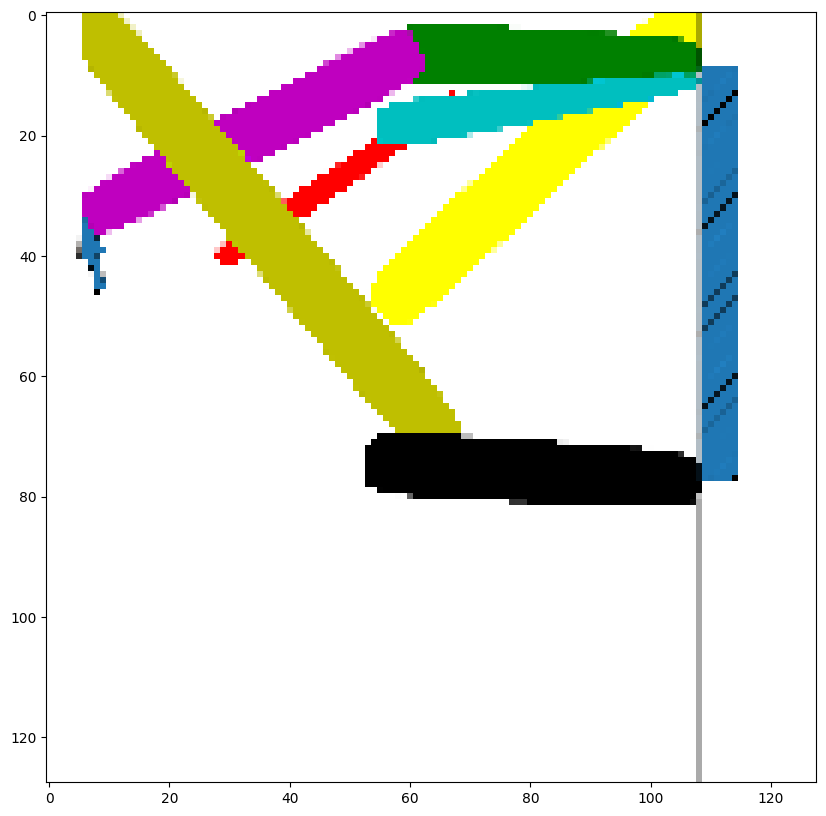

In [47]:
# Assuming you have the expert_dataset defined
expert_dataset = ExpertDataSet(expert_observations, expert_actions, train_env)
# Get a random sample from the dataset
sample_idx = np.random.randint(len(expert_dataset))
sample = expert_dataset[sample_idx]

# Extract the observation and reward from the sample
observation, reward = sample
plt.imshow(observation['image'].T)

In [48]:
chosen_policy = "MlpPolicy" if observation_type == 'box_dense' else "MultiInputPolicy"

feature_extractor = ImageDictExtractor if observation_type == 'image' else CustomBoxDense

# Load the YAML file
env=train_env

with open("algorithms.yaml", "r") as file:
    config = yaml.safe_load(file)

# Extract the parameters for the desired algorithm
algorithm_name = "PPO"  # or "TD3"
algorithm_params = config[algorithm_name]

policy_kwargs = dict(
    features_extractor_class=feature_extractor,
    net_arch = config['common']['net_arch']
)

# Create the model based on the algorithm name and parameters
if algorithm_name == "SAC":
    model = SAC(env=env,
                policy = chosen_policy, 
                policy_kwargs=policy_kwargs,
                device=device, 
                **algorithm_params)

elif algorithm_name == "PPO":
    model = PPO(env=env, 
                policy = chosen_policy, 
                policy_kwargs=policy_kwargs,
                device = device, 
                **algorithm_params)

elif algorithm_name == "TD3":
    # Create the action noise object
    n_actions = env.action_space.shape[-1]
    action_noise_params = algorithm_params.pop("action_noise")
    action_noise = NormalActionNoise(mean=action_noise_params["mean"] * np.ones(n_actions),
                                     sigma=action_noise_params["sigma"] * np.ones(n_actions))
    model = TD3(env=env,
                policy =chosen_policy, 
                policy_kwargs=policy_kwargs,
                action_noise=action_noise,
                device=device, 
                **algorithm_params)

# Get the current date and time
current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")

# Create the tb_log_name string
tb_log_name = f"{algorithm_name}_{current_datetime}"

In [49]:
config['common']['net_arch']

[1024, 1024, 512, 512, 256, 256]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: tensorboard, torch.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/thomasrb/pretraining-rl/22933ee47b374a16a672f0cdaf2a9081
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     grad_norm [157]  : (0.07823491873935069, 2.7521686272692834)
COMET INFO:     mean_reward [7]  : (0.04281383864581585, 0.04423662535846233)
COMET INFO:     std_reward [7]   : (0.0011014359806944289, 0.0014262764845567248)
COMET INFO:     test_loss [157]  : (0.3550886630172945, 1.199415082606883)
COMET INFO:     train_loss [157] : (0.1695249745329864, 1.3454449835832039)
COMET INFO:   Others:
COMET IN

Train Epoch: 1 [0/18936 (0%)]	Loss: 0.168422	Grad Norm: 0.811690	LR: 1.000000
Train Epoch: 1 [35/18936 (26%)]	Loss: 4.017577	Grad Norm: 9.999999	LR: 1.000000
Train Epoch: 1 [70/18936 (53%)]	Loss: 0.845033	Grad Norm: 6.372527	LR: 1.000000
Train Epoch: 1 [105/18936 (79%)]	Loss: 0.640984	Grad Norm: 3.749759	LR: 1.000000
Train set: Average loss: 1.3651
Test set: Average loss: 0.6879
Saved best model to checkpoints/imitation_PPO
Train Epoch: 2 [0/18936 (0%)]	Loss: 0.702603	Grad Norm: 4.588009	LR: 0.990000
Train Epoch: 2 [35/18936 (26%)]	Loss: 0.597066	Grad Norm: 2.587187	LR: 0.990000
Train Epoch: 2 [70/18936 (53%)]	Loss: 0.568512	Grad Norm: 2.021312	LR: 0.990000
Train Epoch: 2 [105/18936 (79%)]	Loss: 0.579050	Grad Norm: 2.677730	LR: 0.990000
Train set: Average loss: 0.6011
Test set: Average loss: 0.6666
Saved best model to checkpoints/imitation_PPO
Train Epoch: 3 [0/18936 (0%)]	Loss: 0.665864	Grad Norm: 4.257371	LR: 0.980100
Train Epoch: 3 [35/18936 (26%)]	Loss: 0.602844	Grad Norm: 2.880615

/home/thomas/anaconda3/envs/SB3_update/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Epoch 20: Mean reward = 0.04 +/- 0.00
Train Epoch: 21 [0/18936 (0%)]	Loss: 0.997809	Grad Norm: 6.439563	LR: 0.817907
Train Epoch: 21 [35/18936 (26%)]	Loss: 0.620516	Grad Norm: 2.537192	LR: 0.817907
Train Epoch: 21 [70/18936 (53%)]	Loss: 0.559534	Grad Norm: 1.659009	LR: 0.817907
Train Epoch: 21 [105/18936 (79%)]	Loss: 0.550503	Grad Norm: 1.356154	LR: 0.817907
Train set: Average loss: 0.6379
Test set: Average loss: 0.5649
Train Epoch: 22 [0/18936 (0%)]	Loss: 0.570239	Grad Norm: 1.766828	LR: 0.809728
Train Epoch: 22 [35/18936 (26%)]	Loss: 0.551605	Grad Norm: 0.972247	LR: 0.809728
Train Epoch: 22 [70/18936 (53%)]	Loss: 0.542628	Grad Norm: 0.723429	LR: 0.809728
Train Epoch: 22 [105/18936 (79%)]	Loss: 0.539372	Grad Norm: 0.838051	LR: 0.809728
Train set: Average loss: 0.5426
Test set: Average loss: 0.5284
Saved best model to checkpoints/imitation_PPO


KeyboardInterrupt: 

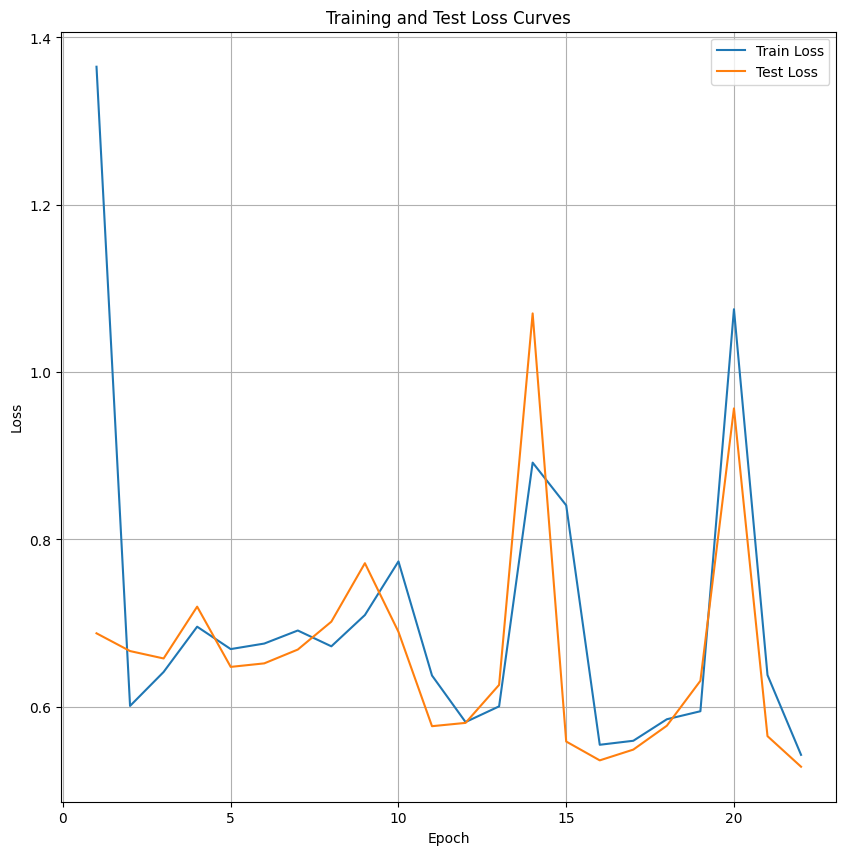

In [60]:
pretrain_agent(
    model,
    expert_observations,
    expert_actions,
    env,
    test_env = eval_env,
    batch_size=1024,
    epochs=1000,
    scheduler_gamma=0.98,
    learning_rate=1.0,
    log_interval=5,
    no_cuda=False,
    seed=1,
    verbose=True,
    test_batch_size=512,
    early_stopping_patience=300,
    plot_curves=True,
    tensorboard_log_dir="tb_logs/imitation",
    save_path="checkpoints/imitation_PPO",
    comet_ml_api_key="No20MKxPKu7vWLOUQCFBRO8mo",
    comet_ml_project_name="pretraining_rl",
    comet_ml_experiment_name="PPO_1",
    eval_freq = 20,
)

---
### Multiprocessing

In [ ]:
#from transformers import AutoTokenizer, AutoModel
from stable_baselines3.common.vec_env import DummyVecEnv, VecCheckNan
import multiprocessing

#tokenizer = AutoTokenizer.from_pretrained("huggingface/CodeBERTa-small-v1")
#model = AutoModel.from_pretrained("huggingface/CodeBERTa-small-v1").to('cuda')

# Set number of cpus to use automatically:
num_cpu = multiprocessing.cpu_count()
# num_cpu = 
print("Using {} cpus!".format(num_cpu))
observation_type = "image"

train_env = sogym(mode='train',observation_type=observation_type,vol_constraint_type = 'hard',resolution=50,check_connectivity=True)#,model=model,tokenizer=tokenizer)
env= make_vec_env(lambda:train_env, n_envs=num_cpu,vec_env_cls=SubprocVecEnv)
env = VecCheckNan(env, raise_exception=True)
#env=VecNormalize(env,gamma=1.0)

eval_env = sogym(mode='test',observation_type=observation_type,vol_constraint_type='hard',resolution=50,check_connectivity=True)#,model=model,tokenizer=tokenizer)
eval_env = make_vec_env(lambda:eval_env, n_envs=1,vec_env_cls=SubprocVecEnv)
#eval_env =VecNormalize(eval_env,gamma=1.0)


--- 
### Defining the model

In [ ]:
chosen_policy = "MlpPolicy" if observation_type == 'box_dense' else "MultiInputPolicy"

feature_extractor = ImageDictExtractor if observation_type == 'image' else CustomBoxDense

# Load the YAML file


with open("algorithms.yaml", "r") as file:
    config = yaml.safe_load(file)

# Extract the parameters for the desired algorithm
algorithm_name = "PPO"  # or "TD3"
algorithm_params = config[algorithm_name]

policy_kwargs = dict(
    features_extractor_class=feature_extractor,
    net_arch = config['common']['net_arch']
)

# Create the model based on the algorithm name and parameters
if algorithm_name == "SAC":
    model = SAC(env=env,
                policy = chosen_policy, 
                policy_kwargs=policy_kwargs,
                device=device, 
                **algorithm_params)

elif algorithm_name == "PPO":
    model = PPO(env=env, 
                policy = chosen_policy, 
                policy_kwargs=policy_kwargs,
                device = device, 
                **algorithm_params)

elif algorithm_name == "TD3":
    # Create the action noise object
    n_actions = env.action_space.shape[-1]
    action_noise_params = algorithm_params.pop("action_noise")
    action_noise = NormalActionNoise(mean=action_noise_params["mean"] * np.ones(n_actions),
                                     sigma=action_noise_params["sigma"] * np.ones(n_actions))
    model = TD3(env=env,
                policy =chosen_policy, 
                policy_kwargs=policy_kwargs,
                action_noise=action_noise,
                device=device, 
                **algorithm_params)

# Get the current date and time
current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")

# Create the tb_log_name string
tb_log_name = f"{algorithm_name}_{current_datetime}"

In [ ]:
# Save a checkpoint every 1000 steps
checkpoint_callback = CheckpointCallback(
  save_freq=5000//num_cpu,
  save_path="./checkpoints/",
  name_prefix=tb_log_name,
  save_replay_buffer=True,
  save_vecnormalize=True,
)

eval_callback = EvalCallback(eval_env,
                             log_path='tb_logs',
                             eval_freq=5000//num_cpu,
                             deterministic=True,
                            n_eval_episodes=10,
                             render=False,
                             best_model_save_path='./checkpoints',
                             verbose=0)



callback_list = CallbackList([eval_callback,
                         checkpoint_callback,
                         MaxRewardCallback(verbose=1),
                         GradientNormCallback(verbose=1),
                         FigureRecorderCallback(check_freq=5000//num_cpu,eval_env=eval_env)
                         ])

--- 
### Training

Save the model:

If model is on-policy:
#model.save("sac_pendulum")
#loaded_model = SAC.load("sac_pendulum")

if model is off-policy, we also need to save the replay buffer:
#model.save_replay_buffer("sac_replay_buffer")
#loaded_model.load_replay_buffer("sac_replay_buffer")

If the environment is normalized:
#env.save('env_saved.pkl')
#env = VecNormalize.load('env_saved.pkl',env)


In [ ]:
#model = SAC.load("model_saved_march15",env =env) #Saved model is with soft volume constraint and 75 r
#model.set_parameters("model_saved_march15")
#print(model.batch_size)
#model.load_replay_buffer("sac_replay_buffer")
model.learn(20000000,
            callback=callback_list, 
            tb_log_name=tb_log_name
            )
#model.save('model_saved_march15',)
#model.save_replay_buffer("sac_replay_buffer_march15")

#env.save('env_saved.pkl')

---
### Let's visualize the agent's performance:

In [ ]:
env=sogym(mode='train',observation_type='image',vol_constraint_type='hard' ,resolution = 50)
#env= make_vec_env(lambda:env, n_envs=1,vec_env_cls=SubprocVecEnv)
env

[-0.7985382  -0.752862   -0.21371634 -0.28959292 -1.         -0.9982842 ]
[-0.91273236 -1.         -0.15354796 -0.458018   -1.         -0.9603455 ]
[-0.9699564  -0.94387025 -0.06384414 -0.501454   -0.28189972 -0.06881419]
[-1.         -1.          0.25044408 -0.324324    0.86665684  1.        ]
[-0.6865837  -0.5671254   0.24398886 -1.          0.82795095  1.        ]
[-0.22336905 -1.          0.81164265 -1.          0.5907694   0.8130534 ]
[-0.3123281 -0.9567458  0.7545531 -1.         0.6878166  1.       ]
[-0.24194662 -0.9917278   0.78831965 -1.          0.6312983   0.95463306]
[-0.29217285 -0.9140467   0.7328711  -1.          0.6650857   0.9877442 ]
[-0.2563602  -0.97141063  0.7541635  -1.          0.53274035  0.91128564]
[-0.63486516 -0.7074695   0.35452577 -0.95662445  0.5400181   0.9866122 ]
[-0.5421702  -0.6313754   0.18513268 -0.8773413   0.45907456  1.        ]
[-0.61433923 -0.519804    0.09917556 -0.87779254  0.4469514   1.        ]
[-0.37301204 -0.73291045  0.48440933 -1.    

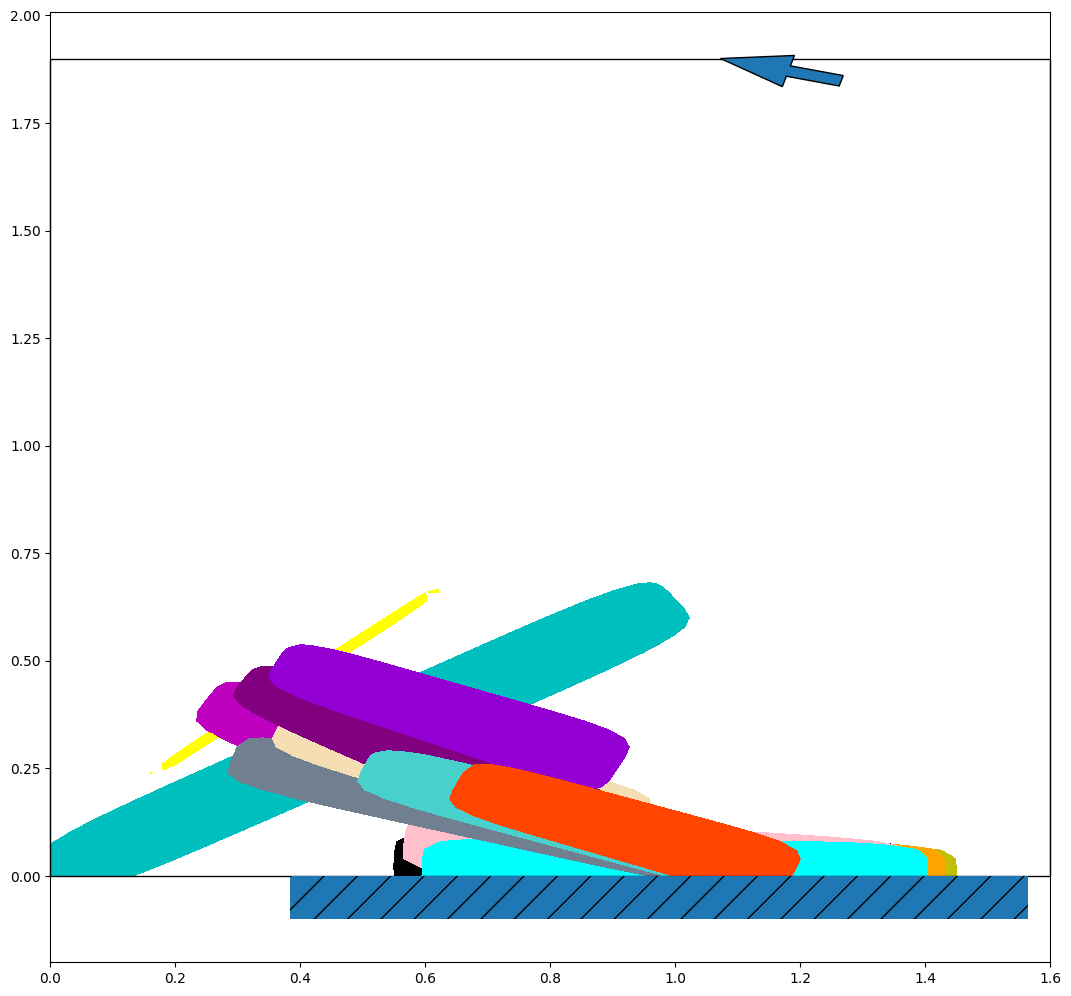

In [59]:
obs,info=env.reset()
dones=False
saved_conditions = env.conditions
saved_nelx, saved_nely = env.nelx, env.nely
saved_dx, saved_dy = env.dx, env.dy
#use deepcopy to save 
while dones== False:
    action, _states = model.predict(obs,deterministic=True)
    print(action)
    obs, rewards, dones,truncated, info = env.step(action)
print("Desired volume:",saved_conditions['volfrac'],"Obtained volume:",env.volume)
#print("Env reward:",rewards, "Compliance:",np.exp(1/rewards))
env.plot()

In [ ]:
xval, f0val,it, H, Phimax, allPhi, den, N, cfg = run_mmc(saved_conditions,saved_nelx,saved_nely,saved_dx,saved_dy,plotting='contour')